# Project: Remaining Useful Life Prediction——NASA Turbofan Engine Data

### Problem Statement:

This project focuses on predicting the Remaining Useful Life (RUL) of aircraft engines using the NASA C-MAPSS dataset. The dataset contains sensor readings from turbofan engines operating under different conditions, with degradation trends leading to failure.

Using machine learning and deep learning models, we aim to develop a predictive maintenance system that estimates when an engine is likely to fail. This helps reduce maintenance costs, prevent unexpected failures, and improve safety in aerospace operations.

### Data

- In engine degradation monitoring, different sensors measure different physical properties of the engine. Some properties increase over time as the engine degrades, while others decrease.
   - Some sensor values INCREASE over time (e.g., temperature, vibration).
   - Some sensor values DECREASE over time (e.g., pressure, efficiency)

- Training Set: Each engine is monitored from start until failure. The model learns patterns of degradation to predict failure trends.
- Test Set: Each engine is monitored without failure information. The final recorded state of the engine is used for model evaluation.
- RUL Set: Contains the actual Remaining Useful Life (RUL) for each engine in the test set, serving as the ground truth for performance assessment.

There are 4 group of datasets (train-test-RUL), in this case study, only the first dataset FD001 is used.

**NOte:**

In this project, max RUL is capped at 150 cycles. Because this cap prevents extreme RUL values from skewing the model and focuses the prediction on the critical degradation phase of the engine

### References
1. Xiang Li, Qian Ding, Jian-Qiao Sun, Remaining useful life estimation in prognostics using deep convolution neural networks, 2018

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

#------------------------------------------
# Import TensorFlow and Keras modules
#------------------------------------------
import tensorflow as tf
tf.random.set_seed(204)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, ReLU, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping



In [2]:
__author__ = "Bing Huang"
__email__ = "Binghuang1990@gmail.com"

# 0. Load Data and DEA

In [3]:
col_names = ['engine_id', 'time', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{s}' for s in range(1, 22)]
df = pd.read_csv("CMAPSSData/train_FD001.txt", header=None, names=col_names, sep='\s+')
df

,engine_id,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [4]:
df.describe()

,engine_id,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [5]:
# only keep valid sensors' data

sensor_ids = [ids for ids in range(1, 22)]
valid_sensor_ids = [2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]
invalid_sensor_ids = [id for id in sensor_ids if id not in valid_sensor_ids]

invalid_sensor_col = [f'sensor_{s}' for s in invalid_sensor_ids]

df = df.drop(columns = invalid_sensor_col)
df.head()

,engine_id,time,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


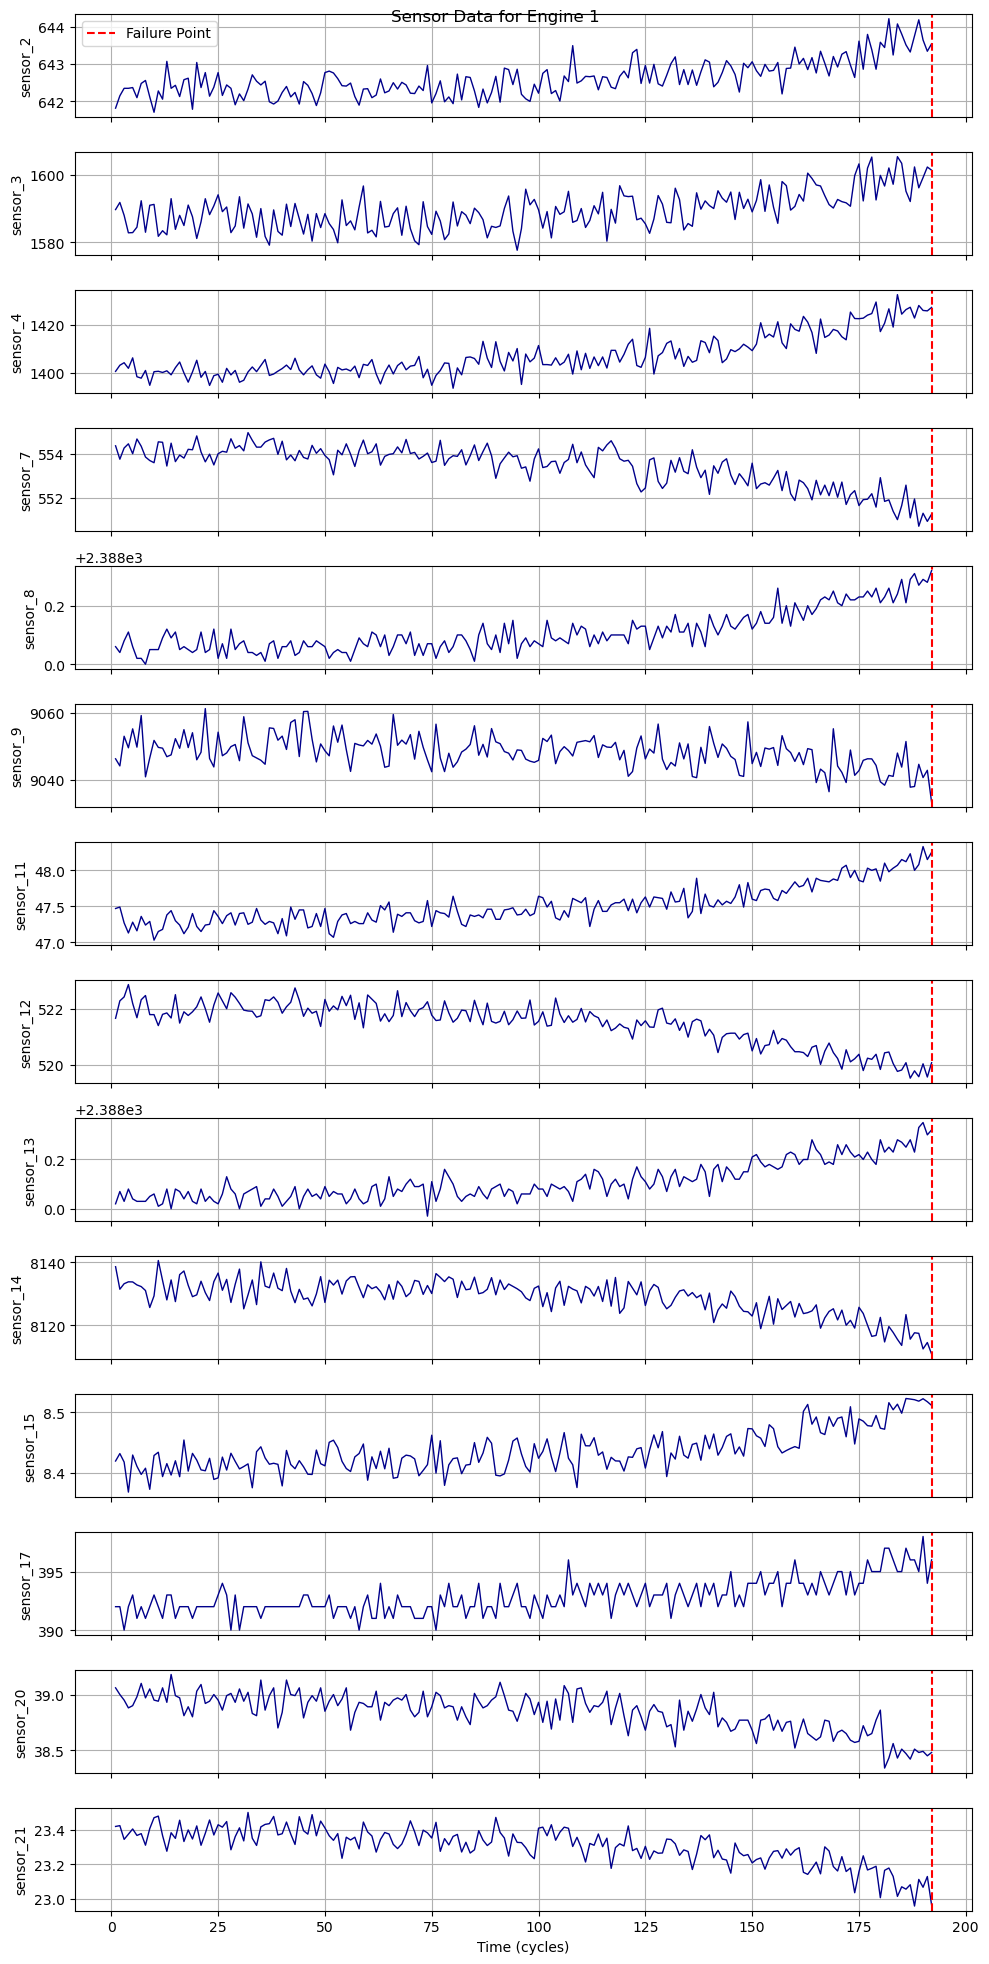

In [6]:
# plot the sensor data for engine 1 over time

df_1 = df[df.engine_id == 1]
sensor_col = [col for col in df.columns if 'sensor_' in col]

# Get failure cycle (last recorded time for Engine 1)
failure_cycle = df_1['time'].max()

# create subplots
fig, ax = plt.subplots(len(sensor_col), 1, figsize =(10, 20), sharex = True)
for i, sensor in enumerate(sensor_col):
    ax[i].plot(df_1['time'], df_1[sensor], color='darkblue', linewidth = 1)
    ax[i].set_ylabel(sensor)
    ax[i].grid(True)
    ax[i].axvline(x=failure_cycle, color='red', linestyle='dashed', label='Failure Point')

ax[0].legend()

plt.xlabel("Time (cycles)")
plt.suptitle(f"Sensor Data for Engine 1")
plt.tight_layout()
plt.show()

# Observations:
# sensor data are in different scale, so data scalling is needed.
# Different sensors measure different physical properties of the engine. 
#  - Some properties increase over time as the engine degrades, e.g., temperature, vibration
#  - while others decrease, e.g., pressure, efficiency

## 0.1. Pre-process the data

In [7]:
# above is to understand the data
# now load train & test datasets, and also propress the training data 

# to load dataset efficiently, define a load_data function
def load_data(filepath, is_train = True, max_rul = 150):
    """
    Loads and preprocesses the CMAPSS dataset for Remaining Useful Life (RUL) prediction
        filepath (str): Path to the dataset
        is_train (bool, optional): If True, computes RUL for training data.
        max_rul (int, optional): Maximum RUL value 150 to cap.
    """
    col_names = col_names = ['engine_id', 'time', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{s}' for s in range(1, 22)]
    df = pd.read_csv(filepath, header=None, names=col_names, sep='\s+')
    
    valid_sensor_ids = [2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]
    invalid_sensor_ids = [s for s in range(1, 22) if s not in valid_sensor_ids]
    invalid_sensor_col = [f'sensor_{s}' for s in invalid_sensor_ids]
    
    df = df.drop(columns = invalid_sensor_col)
    
    if is_train:
        df=df.join(df.groupby('engine_id')['time'].max(), on='engine_id', rsuffix='_max')
        # add column"RUL"
        df['RUL']=(df['time_max'] - df['time']).clip(upper=max_rul)
        df=df.drop(columns=['time_max'])
    
    return df
    

In [8]:
# load train data
df_train = load_data("CMAPSSData/train_FD001.txt", is_train=True, max_rul = 150)
df_train

,engine_id,time,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,150
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,150
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,150
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,150
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [57]:
df_train[df_train.engine_id == 1]

,engine_id,time,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.315972,-1.372920,NaN,-1.721684,-0.134252,-0.925914,1.121113,-0.516326,-0.862792,-0.266460,0.334254,-1.058865,-0.269065,-0.603801,-0.781691,1.348460,1.194398,150
1,1,2,0.872701,-1.031695,NaN,-1.061754,0.211523,-0.643710,0.431920,-0.798074,-0.958794,-0.191578,1.174871,-0.363637,-0.642829,-0.275845,-0.781691,1.016503,1.236892,150
2,1,3,-1.961827,1.015652,NaN,-0.661797,-0.413156,-0.525940,1.008131,-0.234578,-0.557126,-1.015279,1.364688,-0.919819,-0.551616,-0.649128,-2.073044,0.739873,0.503411,150
3,1,4,0.324083,-0.008022,NaN,-0.661797,-1.261284,-0.784812,1.222798,0.188044,-0.713808,-1.539452,1.961255,-0.224592,-0.520163,-1.971617,-0.781691,0.352590,0.777773,150
4,1,5,-0.864590,-0.690471,NaN,-0.621801,-1.251498,-0.301511,0.714376,-0.516326,-0.457048,-0.977838,1.052846,-0.780774,-0.521736,-0.339837,-0.136014,0.463242,1.059526,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,-3.059063,1.015652,NaN,2.137905,1.933876,1.538365,-1.613065,3.005521,-1.237744,1.717909,-2.201156,1.861090,-1.366245,2.094503,1.801015,-1.694477,-3.056838,4
188,1,189,-0.270254,0.674428,NaN,2.997814,0.921015,2.119437,-3.014049,2.442026,-0.937058,2.017436,-2.485881,3.251545,-1.375680,2.030512,1.155339,-1.860455,-1.635140,3
189,1,190,-1.230336,0.333203,NaN,1.917929,1.418475,1.890564,-2.347452,2.723773,-1.116835,2.953460,-1.862197,3.529636,-1.634118,2.137164,3.092369,-1.805129,-2.052689,2
190,1,191,0.004055,-1.372920,NaN,1.317992,1.930614,1.870565,-2.765487,2.582900,-1.018116,2.279523,-2.499439,2.834409,-1.527703,2.006515,0.509662,-2.026434,-1.479945,1


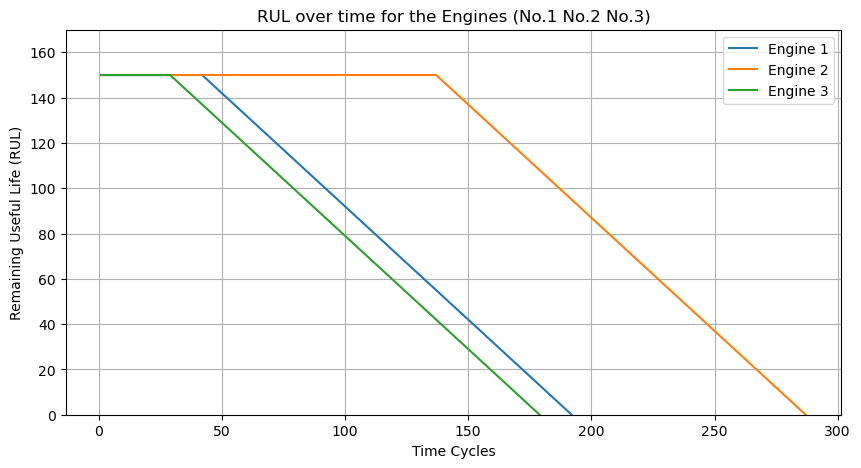

In [13]:
# plot the first three engine RUL

first_five_engines = df_train[df_train['engine_id'].isin(df['engine_id'].unique()[:3])]

plt.figure(figsize=(10, 5))

for engine_id in first_five_engines['engine_id'].unique():
    engine_data = first_five_engines[first_five_engines['engine_id'] == engine_id]
    plt.plot(engine_data['time'], engine_data['RUL'], label=f'Engine {engine_id}')

plt.xlabel('Time Cycles')
plt.ylabel('Remaining Useful Life (RUL)')
plt.ylim(0, 170)
plt.title('RUL over time for the Engines (No.1 No.2 No.3)')
plt.legend()
plt.grid()
plt.show()

In [14]:
# load test data-- 每个engine提前终止 没有到最后， 所以需要加上true RULtime
df_test = load_data("CMAPSSData/test_FD001.txt", is_train=False)
df_test_last = df_test.groupby('engine_id').last().reset_index()

df_rul = pd.read_csv("CMAPSSData/RUL_FD001.txt", header=None, names=['RUL'])
df_rul['engine_id'] = range(1, 101)
df_test = df_test_last.merge(df_rul, on='engine_id')
df_test

,engine_id,time,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,31,-0.0006,0.0004,100.0,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552,112
1,2,49,0.0018,-0.0001,100.0,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618,98
2,3,126,-0.0016,0.0004,100.0,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740,69
3,4,106,0.0012,0.0004,100.0,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581,82
4,5,98,-0.0013,-0.0004,100.0,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,-0.0006,0.0003,100.0,642.30,1590.88,1397.94,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391,38.96,23.4606,137
96,97,134,0.0013,-0.0001,100.0,642.59,1582.96,1410.92,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395,38.61,23.2953,82
97,98,121,0.0017,0.0001,100.0,642.68,1599.51,1415.47,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394,38.76,23.3608,59
98,99,97,0.0047,-0.0000,100.0,642.00,1585.03,1397.98,554.75,2388.01,9067.16,47.26,521.82,2388.02,8150.38,8.4003,391,38.95,23.3595,117


## 0.2. Prepare Train and Test data

In [15]:
# train and test dataset
X_train = df_train.drop(columns =["engine_id", 'op_setting_1', 'op_setting_2', 'op_setting_3', 'time', 'RUL'])
y_train = df_train['RUL']

X_test = df_test.drop(columns =["engine_id", 'op_setting_1', 'op_setting_2', 'op_setting_3', 'time', 'RUL'])
y_test = df_test['RUL']

X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((20631, 14), (20631,), (100, 14), (100,))

In [16]:
# scale data 
# ML -standard scale 
# note: SVM, LG need standard scalling, while tree-based models donot need
#       CNN, LSTM pften use min-max scalling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
X_train

In [17]:
# define score function 
def score_function(y_true, y_pred):
    """
    Computes the prognostics-specific score function.
    Penalizes late predictions more than early ones.
    """
    error = y_pred - y_true  # Prediction error
    score = np.where(error < 0, np.exp(-error / 13) - 1, np.exp(error / 10) - 1)
    return np.sum(score)

# Example Usage:
y_true = np.array([100, 80, 60, 40, 20])  # True RUL values
y_pred = np.array([110, 75, 65, 35, 10])  # Predicted RUL values

score = score_function(y_true, y_pred)
print(f"Prognostics Score: {score:.2f}")

Prognostics Score: 4.46


# **1. Traditional ML Models**

ML models used hear include:
- Linear Regression (Righe/Lasso)
- Random Forest
- XGBoost



Two model metrics are commony used in Prognostics and Health Management:
- scoring function: penalizes late prediction more than early prediction
- root mean sqaure error



In [18]:
# define score function 

def score_function(y_true, y_pred):
    """
    Computes the prognostics-specific score function.
    Penalizes late predictions more than early ones.
    """
    error = y_pred - y_true  
    score = np.where(error < 0, np.exp(-error / 13) - 1, np.exp(error / 10) - 1)
    return np.sum(score)

## 1.1 Define, Train and Evaluate models

In [19]:
ML_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

result = []

for name, model in ML_models.items():
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    
    rmse=mean_squared_error(y_test, y_pred, squared=False)
    score=score_function(y_test, y_pred)
    
    result.append((name, rmse, score))
    print(f"{name} -> RMSE: {rmse:.2f}, Score: {score:.2f}")

Linear Regression -> RMSE: 23.87, Score: 2574.11
Ridge Regression -> RMSE: 23.87, Score: 2573.98
Lasso Regression -> RMSE: 23.88, Score: 2574.85
Random Forest -> RMSE: 22.12, Score: 3322.24
XGBoost -> RMSE: 21.93, Score: 2463.86


In [20]:
# convert into dataframe
df_ML_results = pd.DataFrame(result, columns=['Model', 'RMSE', 'Score'])
df_ML_results.sort_values(by='Score', ascending=True, inplace=True) # returning without create a df
df_ML_results

,Model,RMSE,Score
4,XGBoost,21.929335,2463.859097
1,Ridge Regression,23.874299,2573.980882
0,Linear Regression,23.874482,2574.114833
2,Lasso Regression,23.877264,2574.848880
3,Random Forest,22.121759,3322.241690


## 1.2 Plot Predict vs. Actual RUL values

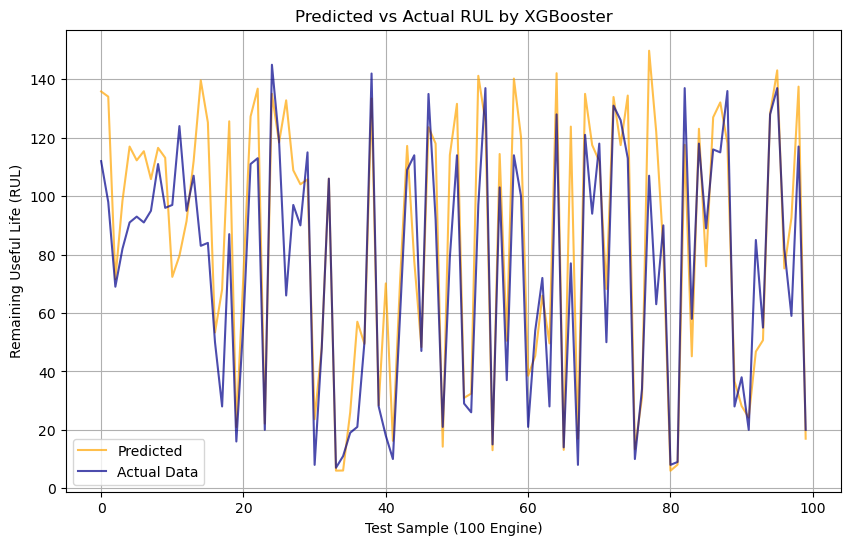

In [21]:

best_model = ML_models["XGBoost"]  
y_pred = best_model.predict(X_test) 

y_test = np.array(y_test)
y_pred = np.array(y_pred)
plt.figure(figsize=(10,6))
plt.plot(range(len(y_pred)), y_pred, label="Predicted", color="orange", alpha=0.7)
plt.plot(range(len(y_test)), y_test, label="Actual Data", color="darkblue", alpha=0.7)
plt.xlabel("Test Sample (100 Engine)")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title("Predicted vs Actual RUL by XGBooster")

plt.legend()
plt.grid()
plt.show()

# it is clear to see that in most cases Predicted Values are larger than the actual RUL values.

# **2. CNN Model**

## 2.1 Prepare the data -- sequential windows

As this is a time-series data, so we need to covert raw sensor data into **sequential windows**

**Why?**

If we train on single time points instead of using sliding windows:  The model *does not* learn trends or degradation patterns!!
for degradation data:
- degradation does not happen suddenly -- depends on past sensor readings
- Machine degadation -- a gradual process

**How?**

- we make a time-step with 30; group every 30 cycles and then there is a target RUL

In [76]:
df_train

,engine_id,time,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,150
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,150
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,150
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,150
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [33]:
df_train.iloc[:, 2:-1] = df_train.iloc[:, 2:-1].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
df_train

C:\Users\bingh\AppData\Local\Temp\ipykernel_48984\1194832637.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       -0.781691
1       -0.781691
2       -2.073044
3       -0.781691
4       -0.136014
           ...   
20626    2.446692
20627    1.155339
20628    3.092369
20629    1.155339
20630    1.801015
Name: sensor_17, Length: 20631, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.iloc[:, 2:-1] = df_train.iloc[:, 2:-1].apply(lambda x: (x - x.mean()) / x.std(), axis=0)


,engine_id,time,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.315972,-1.372920,NaN,-1.721684,-0.134252,-0.925914,1.121113,-0.516326,-0.862792,-0.266460,0.334254,-1.058865,-0.269065,-0.603801,-0.781691,1.348460,1.194398,150
1,1,2,0.872701,-1.031695,NaN,-1.061754,0.211523,-0.643710,0.431920,-0.798074,-0.958794,-0.191578,1.174871,-0.363637,-0.642829,-0.275845,-0.781691,1.016503,1.236892,150
2,1,3,-1.961827,1.015652,NaN,-0.661797,-0.413156,-0.525940,1.008131,-0.234578,-0.557126,-1.015279,1.364688,-0.919819,-0.551616,-0.649128,-2.073044,0.739873,0.503411,150
3,1,4,0.324083,-0.008022,NaN,-0.661797,-1.261284,-0.784812,1.222798,0.188044,-0.713808,-1.539452,1.961255,-0.224592,-0.520163,-1.971617,-0.781691,0.352590,0.777773,150
4,1,5,-0.864590,-0.690471,NaN,-0.621801,-1.251498,-0.301511,0.714376,-0.516326,-0.457048,-0.977838,1.052846,-0.780774,-0.521736,-0.339837,-0.136014,0.463242,1.059526,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.178817,-1.031695,NaN,1.617961,1.216229,2.188322,-2.189276,1.315035,0.012546,1.979996,-2.607906,2.278227,-0.322534,1.425260,2.446692,-1.805129,-2.921042,4
20627,100,197,-0.727436,-1.714145,NaN,1.717950,2.279651,2.738285,-2.833277,1.878530,-0.006020,1.867673,-2.350298,1.722045,-0.380198,1.913194,1.155339,-2.856326,-1.203735,3
20628,100,198,0.186928,-0.008022,NaN,1.477975,1.946924,2.138325,-2.742891,2.019404,0.029754,2.054877,-1.902872,2.000136,-0.141680,3.265013,3.092369,-2.081760,-3.292402,2
20629,100,199,-0.498845,1.015652,NaN,1.098016,2.403608,1.955004,-3.036645,2.160278,0.383875,3.178105,-2.363856,1.861090,-0.233942,2.579771,1.155339,-2.911652,-2.085021,1


In [34]:
def get_engine(df, engine_id):
    return df[df["engine_id"] == engine_id]

In [35]:
valid_sensor_cols = [f'sensor_{s}' for s in valid_sensor_ids]
x = df_train[["engine_id"] + valid_sensor_cols]
y = df_train[["engine_id",'RUL']]

window_size = 30
    
def input_tensors(x, y, engine_ids, window_size=30):
    x_sequences = []
    y_sequences = []

    for engine_id in engine_ids:
        x_seq = get_engine(x, engine_id).drop(columns=['engine_id']).values  # Remove engine_id for model input
        y_seq = get_engine(y, engine_id)['RUL'].values  # Convert y to array


        for t in range(len(x_seq) - window_size):
            x_sequences.append(x_seq[t:t + window_size])
            y_sequences.append(y_seq[t + window_size])  # Ensure it does not go out of bounds

    x = np.array(x_sequences)
    y = np.array(y_sequences)

    return x, y


n_train = 70 # the first 70
id_train = x.engine_id.unique()[:n_train]
id_test = x.engine_id.unique()[n_train:]
x_train, y_train = input_tensors(x, y, id_train)
x_test, y_test = input_tensors(x, y, id_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(12030, 30, 14)
(12030,)
(5601, 30, 14)
(5601,)


## 2.1 Build, Train and Compile a CNN model 

In [36]:
input_shape = (x_train.shape[1], x_train.shape[2])
#----------------
# Create a CNN model
#------------------
model = Sequential()
#----------------
# Add convolutional layers
#------------------
model.add(Conv1D(16, kernel_size=10, activation='relu', input_shape=input_shape, padding='same'))
model.add(Conv1D(16, kernel_size=10, activation='relu', padding='same'))
model.add(Conv1D(1, kernel_size=5, activation='relu', padding='same'))

#----------------
# Add full connected layers
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.05))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 16)            2256      
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 16)            2576      
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 1)             81        
                                                                 
 flatten (Flatten)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 16)                496       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [39]:
optimizers_adam = Adam(learning_rate = 0.001)

model.compile(
    optimizer=optimizers_adam , 
    loss='mean_squared_error',  # Loss function
    metrics=['mae']  # Evaluation metric
)

In [40]:


early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor (validation loss)
    patience=10,             # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the best epoch
)

history = model.fit(x_train, 
            y_train, 
            epochs=100, 
            batch_size=16, 
            validation_data=(x_test, y_test), 
            verbose=1,
            callbacks=[early_stopping])

Epoch 1/100
752/752 [==============================] - 24s 31ms/step - loss: 1436.5582 - mae: 28.0008 - val_loss: 575.5454 - val_mae: 19.1758
Epoch 2/100
752/752 [==============================] - 50s 67ms/step - loss: 466.0960 - mae: 16.5704 - val_loss: 479.7911 - val_mae: 17.4729
Epoch 3/100
752/752 [==============================] - 31s 41ms/step - loss: 354.3988 - mae: 14.2769 - val_loss: 473.0741 - val_mae: 17.2696
Epoch 4/100
752/752 [==============================] - 21s 28ms/step - loss: 328.1984 - mae: 13.6860 - val_loss: 471.1903 - val_mae: 17.0111
Epoch 5/100
752/752 [==============================] - 27s 36ms/step - loss: 292.0912 - mae: 12.8681 - val_loss: 442.0786 - val_mae: 16.6495
Epoch 6/100
752/752 [==============================] - 30s 39ms/step - loss: 258.3137 - mae: 12.0604 - val_loss: 467.4794 - val_mae: 17.0237
Epoch 7/100
752/752 [==============================] - 28s 38ms/step - loss: 243.7514 - mae: 11.6376 - val_loss: 468.2281 - val_mae: 16.9654
Epoch 8/100


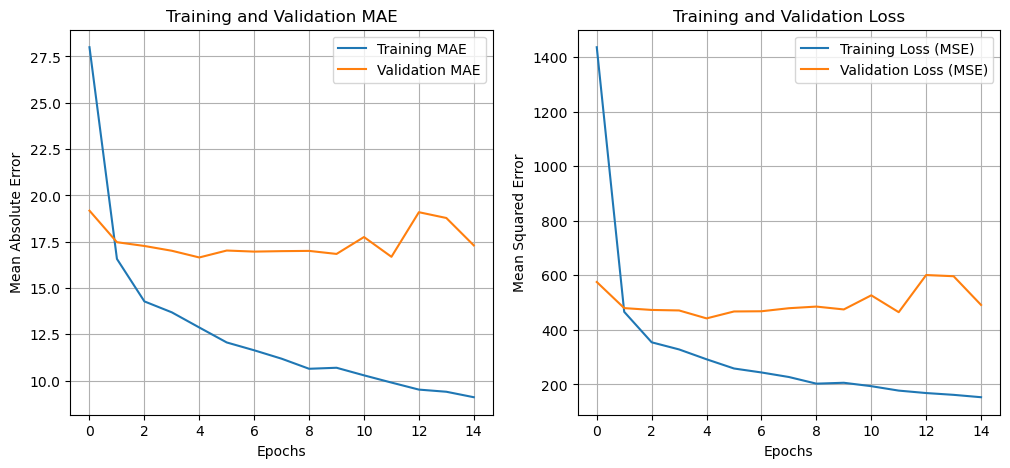

In [42]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend()
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.grid()
plt.title('Training and Validation MAE')

# Plot Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss (MSE)')
plt.plot(val_loss, label='Validation Loss (MSE)')
plt.legend()
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.grid()
plt.title('Training and Validation Loss')

plt.show()


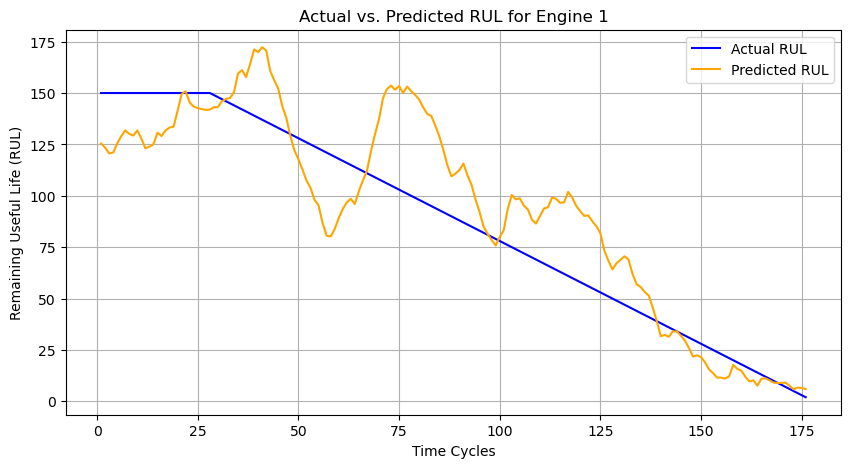

In [ ]:
# Extract first engine's data 
engine_1_length = 176  # SLIDING WINDOWS 30

y_test_engine1 = y_test[:engine_1_length]  
y_pred_engine1 = y_pred[:engine_1_length]  

time_axis = range(1, engine_1_length + 1)  

plt.figure(figsize=(10, 5))

# Plot actual RUL
plt.plot(time_axis, y_test_engine1, label='Actual RUL',color='blue')
plt.plot(time_axis, y_pred_engine1, label='Predicted RUL',  color='orange')

# Formatting
plt.xlabel('Time Cycles')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Actual vs. Predicted RUL for Engine 1')
plt.legend()
plt.grid()
plt.show()

